In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib 
#import swifter
from scipy import stats
import pandahouse
%matplotlib inline

In [1]:
connection = {
    'host': '*********',
    'password': '*********',
    'user': '*********',
    'database': '*********'
}

### АA тест с 2023-02-23 по 2023-03-01.

In [4]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-02-23' and '2023-03-01'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

df.groupby('exp_group')['user_id'].nunique()

exp_group
2    8480
3    8569
Name: user_id, dtype: int64

In [5]:
df

,exp_group,user_id,likes,views,ctr
0,3,115383,11,36,0.305556
1,3,123580,15,92,0.163043
2,2,131473,26,148,0.175676
3,2,23985,12,66,0.181818
4,2,24523,17,120,0.141667
...,...,...,...,...,...
17044,3,122008,4,31,0.129032
17045,2,25383,16,57,0.280702
17046,3,122190,25,74,0.337838
17047,2,108927,8,33,0.242424


### График распределения CTR по группам

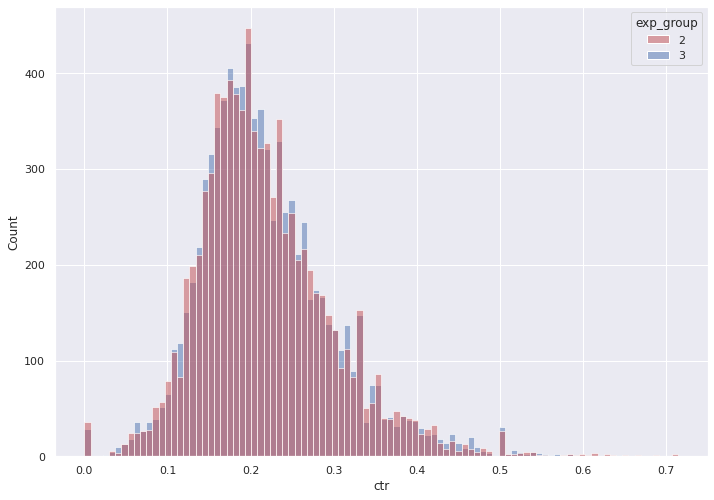

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Распределение унимодально, без явных выбросов. Можем применить t-test

In [7]:
stats.ttest_ind(df.query('exp_group==2')['ctr'],
               df.query('exp_group==3')['ctr'],
               equal_var=False)

Ttest_indResult(statistic=-0.7393597924958364, pvalue=0.45969873156476293)

#### pvalue намного меньше 0,05, что говорит о том, что между нашими выборками нет статистически значимых различий. Проведем данный тест мдогократно (10000) и посмотрим в каком количестве % тестов результат будет говорит о том, что выявлены статистически значимые различия. 

In [8]:
p_values = []
for step in range(10000):
    p = stats.ttest_ind(df.query('exp_group==2')['ctr'].sample(500, replace=True),
                        df.query('exp_group==3')['ctr'].sample(500, replace=True),
                        equal_var=False)[1]
    p_values.append(p)

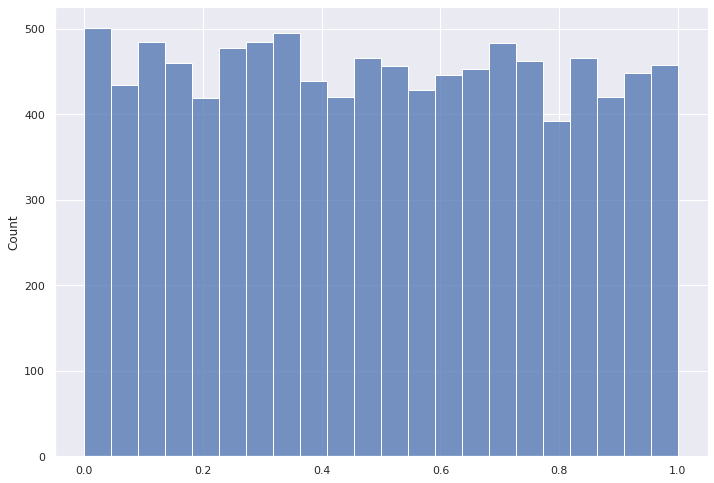

In [9]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data=p_values)

Получили равномерное распределение.  
Посчитаем процент p values, который оказался <= 0,05 

In [10]:
alt_pval = [x for x in p_values if x <= 0.05]
len(alt_pval) / 10000

0.0538

### Вывод
Наша система сплитования пользователей коректно отрабатывает. Мы отклоняем нулевую гипотезу примерно в 5% случаев (случайное ложное срабатывание)